In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import math
import os

In [50]:
random.seed(300)

In [51]:
def pick_category(category_weights):
    total_weight = sum(category_weights.values())
    rand_num = random.uniform(0, total_weight)
    cumulative_weight = 0
    for category, weight in category_weights.items():
        cumulative_weight += weight
        if rand_num < cumulative_weight:
            return category

In [52]:
def age_dist(path):
    data = pd.read_csv(path)
    dict = data.to_dict('index')
    final_dict = {}
    for i, row in enumerate(dict.values()):
        final_dict[i] = row['Probability']
    return final_dict
# Read the data from the file - src 2020
# can be region specific - is available from UN
d = age_dist('dist.csv')

In [53]:
def graphs(category, n, m, k, p):
  graph1 = nx.barabasi_albert_graph(n, m, seed = 300)
  graph2 = nx.watts_strogatz_graph(n, k, p, seed = 300)
  for i in range(n):
    r = pick_category(category)
    j = pick_category(d)
    graph1.nodes[i]["age"] = j
    graph1.nodes[i]["type"] = r
    graph1.nodes[i]["next_type"] = r
    graph2.nodes[i]["age"] = j
    graph2.nodes[i]["type"] = r
    graph2.nodes[i]["next_type"] = r

  return graph1, graph2

In [54]:
def timesteps(g, num_steps, params):
  data = pd.DataFrame({'num_a': [], 'num_ab': [], 'num_b': [], 'time': []})
  for i in range(num_steps):
    d = one_step(g, i, params)
    data.loc[len(data)] = d

  return data, g

In [55]:
def one_step(g, time, params):
  # load previous step
  num_a = 0
  num_ab = 0
  num_b = 0
  for i in range(g.number_of_nodes()):
    g.nodes[i]["type"] = g.nodes[i]["next_type"]
    t = g.nodes[i]["type"]
    if (t == 0):
      num_a += 1
    elif (t == 1):
      num_ab += 1
    else:
      num_b += 1
  
    type = actor_evaluate(g, i, params)

    g.nodes[i]["next_type"] = type

  params["n"] = g.number_of_nodes()
  return [num_a, num_ab, num_b, time]

In [56]:
def r(t, r_0, a, t_c, delta):
    if (t < t_c):
        return r_0
    else:
        return r_0 * (1 - (1/1+ math.exp(-a*(t-t_c-delta))))

In [57]:
def actor_evaluate(g, i, params):
  a_sum = 0
  ab_sum = 0
  b_sum = 0
  for j in g.neighbors(i):
    # find the neighbors type
    if g.nodes[j]["type"] == 0:
      a_sum += 1
    elif g.nodes[j]["type"] == 1:
      ab_sum += 1
    else:
      b_sum += 1

  b_sum /= g.degree(i)
  a_sum /= g.degree(i)
  ab_sum /= g.degree(i)
  
  new_type = 0
  decay = r(g.nodes[i]["age"], params['r_0'], params['a'], params['t_c'], params['delta'])
  p_a_ab = 0.5 * decay * b_sum
  p_b_ab = 0.5 * decay * a_sum
  p_ab_b = 0.5 * decay * (1 - a_sum)
  p_ab_a = 0.5 * decay * (1 - b_sum)
  
  rand = random.uniform(0, 1)
  if (g.nodes[i]["type"] == 0):
    if (rand < p_a_ab):
      new_type = 1
    else:
      new_type = 0
  elif (g.nodes[i]["type"] == 1):
    if (rand < p_ab_b):
      new_type = 2
    elif (rand < p_ab_a):
      new_type = 0
    else:
      new_type = 1
  elif (g.nodes[i]["type"] == 2):
    if (rand < p_b_ab):
      new_type = 1
    else:
      new_type = 2
  
  return new_type

We know y = 3. Observe and use the following: http://networksciencebook.com/chapter/5#non-linear

In [58]:
def test_graphs(params, path, metadata=False):
  os.makedirs(path, exist_ok=True)
  n = params['n']
  m = params['m']
  k = params['k']
  p = params['p']
  iter = params['iter']
  dist = params['dist']
  
  # Barabasi-Albert  
  G1, G2 = graphs(dist, n, m, k, p)
  
  df, G1 = timesteps(G1, iter, params)
  df.head()
  df.plot(x='time', y=['num_a', 'num_ab', 'num_b'], title='Barabasi-Albert')
  
  df.to_csv(path + 'barabasi.csv')
  
  # Degree Distribution of Barabasi-Albert
  max_degree = 0
  
  for i in G1.nodes():
      if G1.degree(i) > max_degree:
          max_degree = G1.degree(i)
  
  x_degree_b = []
  y_tmp = []
  
  for i in range(max_degree + 1):
      x_degree_b.append(i)
      y_tmp.append(0)
      for j in G1.nodes():
          if G1.degree(j) == i:
              y_tmp[i] += 1
      y_degree_b = [i / n for i in y_tmp] 
  
  # Watts-Strogatz
  
  df, G2 = timesteps(G2, iter, params)
  df.head()
  df.plot(x='time', y=['num_a', 'num_ab', 'num_b'], title='Watts-Strogatz')
  
  df.to_csv(path + 'strogatz.csv')
  
  # Degree Distribution of Watts-Strogatz
  max_degree = 0
  
  for i in G2.nodes():
      if G2.degree(i) > max_degree:
          max_degree = G2.degree(i)
  
  x_degree_w = []
  y_tmp = []
  
  for i in range(max_degree + 1):
      x_degree_w.append(i)
      y_tmp.append(0)
      for j in G2.nodes():
          if G2.degree(j) == i:
              y_tmp[i] += 1
      y_degree_w = [i / n for i in y_tmp] 
    
  x_age = []
  y_age = []
  
  for i in range(100):
    x_age.append(i)
    y_age.append(0)
    for j in G2.nodes():
        if G2.nodes[j]["age"] == i:
            y_age[i] += 1
    y_age[i] /= n

  plt.show()
  
  if metadata:
    barabasi_degree_df = pd.DataFrame({'log(k)': x_degree_b, 'log(p(k))': y_degree_b})
    barabasi_degree_df.to_csv(path + 'barabasi_degree.csv')
    
    strogatz_degree_df = pd.DataFrame({'log(k)': x_degree_w, 'log(p(k))': y_degree_w})
    strogatz_degree_df.to_csv(path + 'strogatz_degree.csv')
    
    age_df = pd.DataFrame({'Age': x_age, 'Proportion': y_age})
    age_df.to_csv(path + 'age.csv')

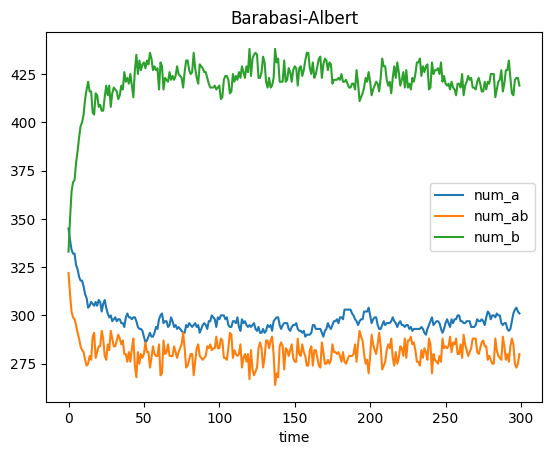

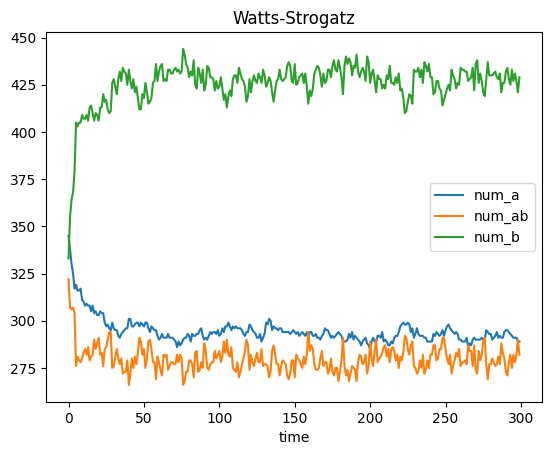

In [63]:
params = {
    'n': 1000,
    'm': 3,
    'k': 4,
    'p': 0.3,
    'iter': 300,
    'dist': {0: 0.33, 1: 0.33, 2: 0.33},
    't_c': 17,
    'r_0': 1,
    'delta': 0.5,
    'a': 1,
    'death_age': 73
}

save_path = 'experiment1/'

test_graphs(params, save_path, metadata=True)

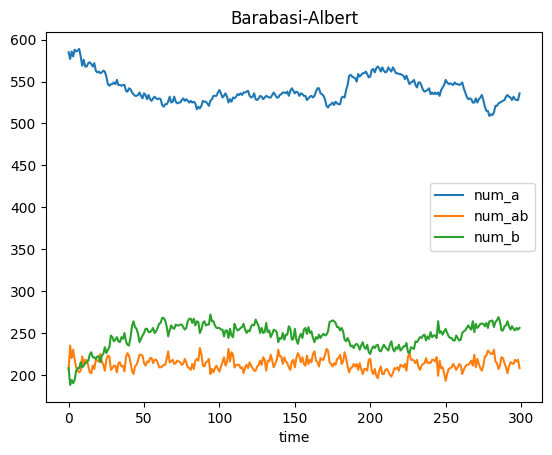

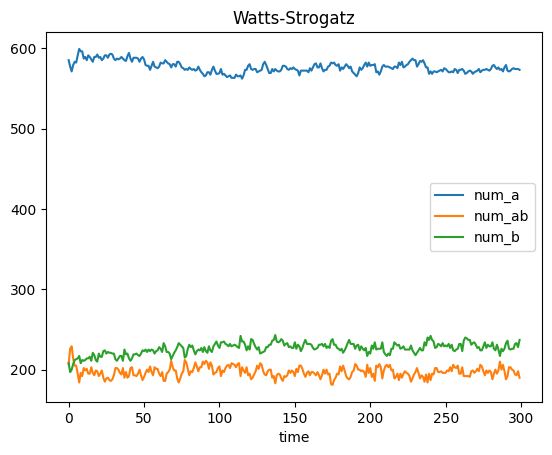

In [60]:
params = {
    'n': 1000,
    'm': 3,
    'k': 4,
    'p': 0.3,
    'iter': 300,
    'dist': {0: 0.6, 1: 0.2, 2: 0.2},
    't_c': 17,
    'r_0': 1,
    'delta': 0.5,
    'a': 1,
    'death_age': 73
}

save_path = 'experiment2/'

test_graphs(params, save_path, metadata=False)

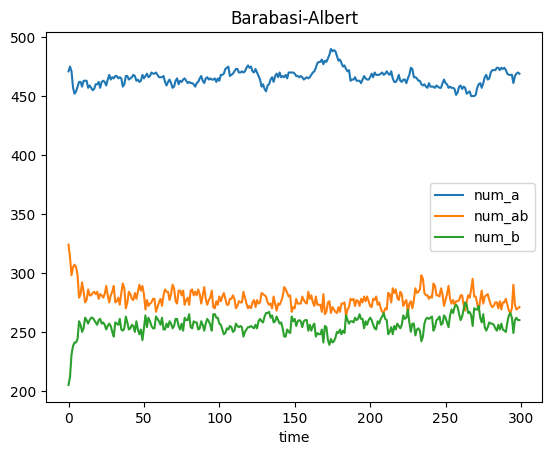

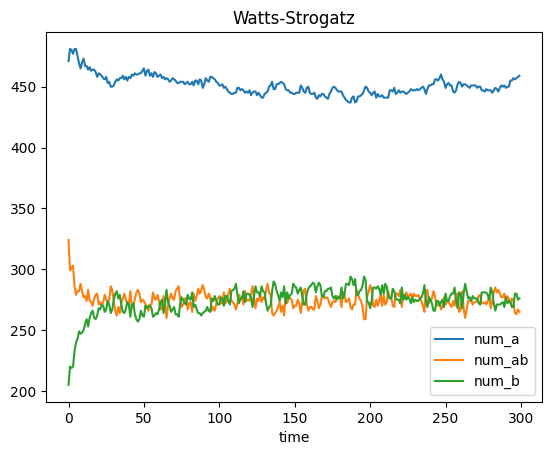

In [61]:
params = {
    'n': 1000,
    'm': 3,
    'k': 4,
    'p': 0.3,
    'iter': 300,
    'dist': {0: 0.5, 1: 0.3, 2: 0.2},
    't_c': 17,
    'r_0': 1,
    'delta': 0.5,
    'a': 1,
    'death_age': 73
}

save_path = 'experiment3/'

test_graphs(params, save_path, metadata=False)

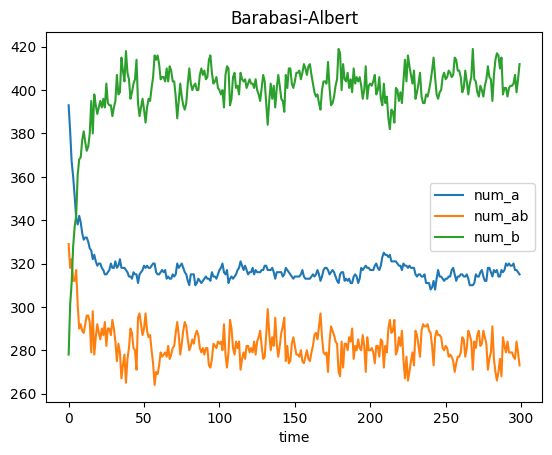

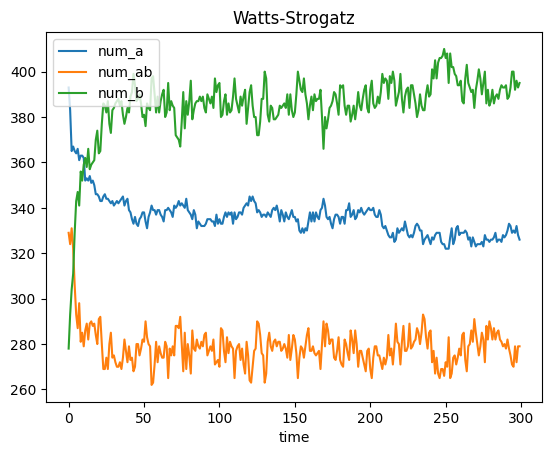

In [62]:
params = {
    'n': 1000,
    'm': 3,
    'k': 4,
    'p': 0.3,
    'iter': 300,
    'dist': {0: 0.4, 1: 0.3, 2: 0.3},
    't_c': 17,
    'r_0': 1,
    'delta': 0.5,
    'a': 1,
    'death_age': 73
}

save_path = 'experiment4/'

test_graphs(params, save_path, metadata=False)